# About the Notebook

In this kernel, I will present a simple linear regression model combined with more advanced concepts, such as *data manipulation, data distribution, multicollinearity, polynomial relationships* etc., and present ways to deal with these problems.

I chose a simple data set to allow a better understanding of these concepts. Notice how applying these tools will improve the fitting  test results and the quality of your predictions.

I am sometimes using different terms that might imply the same thing. For example, features and variables, or target and response. It is important to know all of the terms that are being used by the community.

If you have any question or suggestions, please don't hesitate to comment!

**If you like this kernel, please don't hesitate to UPVOTE :)**

## The Importance of Predicting House Prices

Are you planning on buying a house for investment, and wondering which house would be the best buy? Are you planning to renovate your house to increase its value on the market, but don't know where to invest the most to get the best results? Do you have a real-estate company that wants to give the best machine-learning based solutions to its customers? You are in the right place!

In this notebook, I will analize house sales in King County, WA, USA between 2014 to 2015.  

Let's start by looking the maps below: the top image is the King County region; the bottom image is downtown Seattle, the capital of Washington.

<img align="center" src="https://imgur.com/O1ImtR8.png" width="700" hight="550" title="King County Region, WA, USA" />
<img align="center" src="https://imgur.com/culbAe4.png" width="700" hight="250" title="Downtown Seattle" />

# Explore the Data

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import distance
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
plt.rcParams["axes.labelsize"] = 15

from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.transform import log_cmap
from bokeh.models import ColumnDataSource, LogTicker, ColorBar #, HoverTool, CategoricalColorMapper, LogColorMapper
from bokeh.models.formatters import BasicTickFormatter, NumeralTickFormatter
import bokeh.palettes as bp

output_notebook()
%matplotlib inline

Loading BokehJS ...

Let's read the data, look at the head of the table and the information about the features.

In [2]:
df = pd.read_csv('../input/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


The dataframe contains 19 house features, plus the price and the ID columns, along with 21613 observations.

The ID column doesn't contribute any insight into the data, and neither does the date, as all of the data is from 2014 to 2015. Let's drop those columns.

In [4]:
df.drop(['id', 'date'], axis=1, inplace=True)
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Data Visualization

Let's have a look at the different features and their relation to the price of the house, starting with the discrete variables.

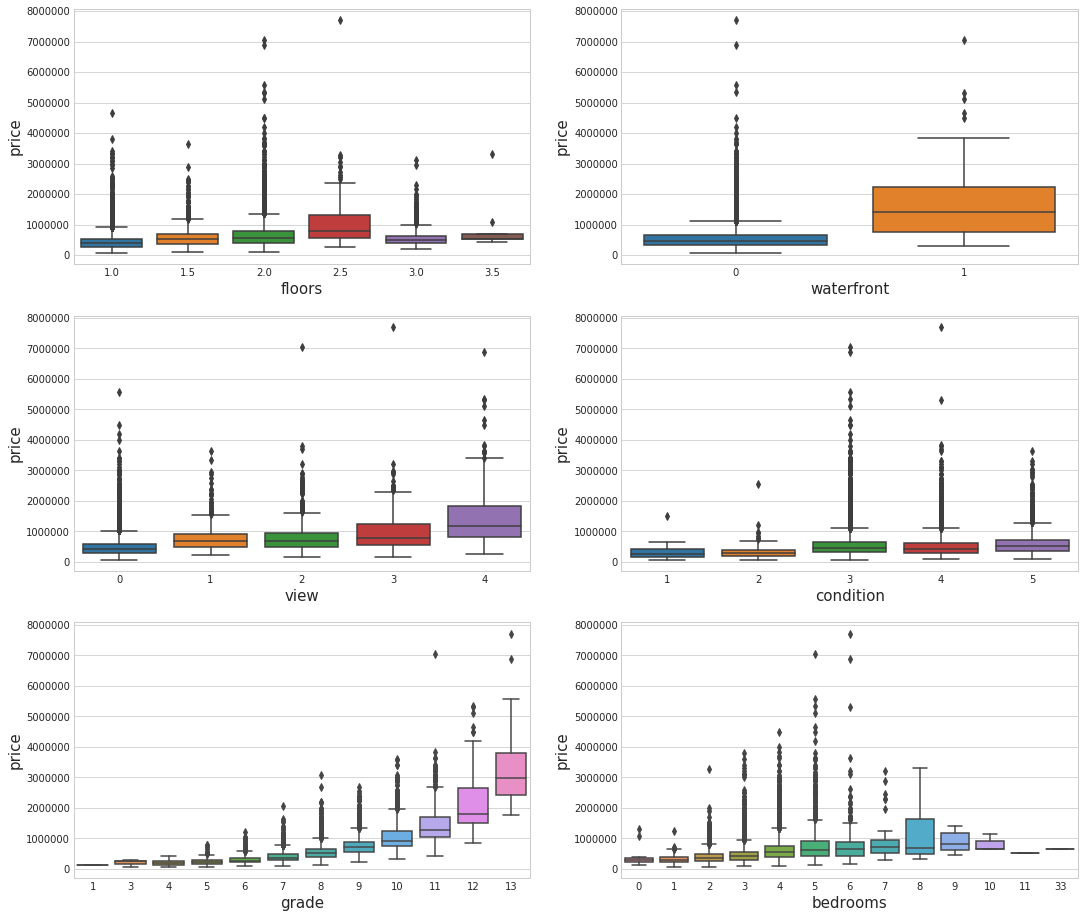

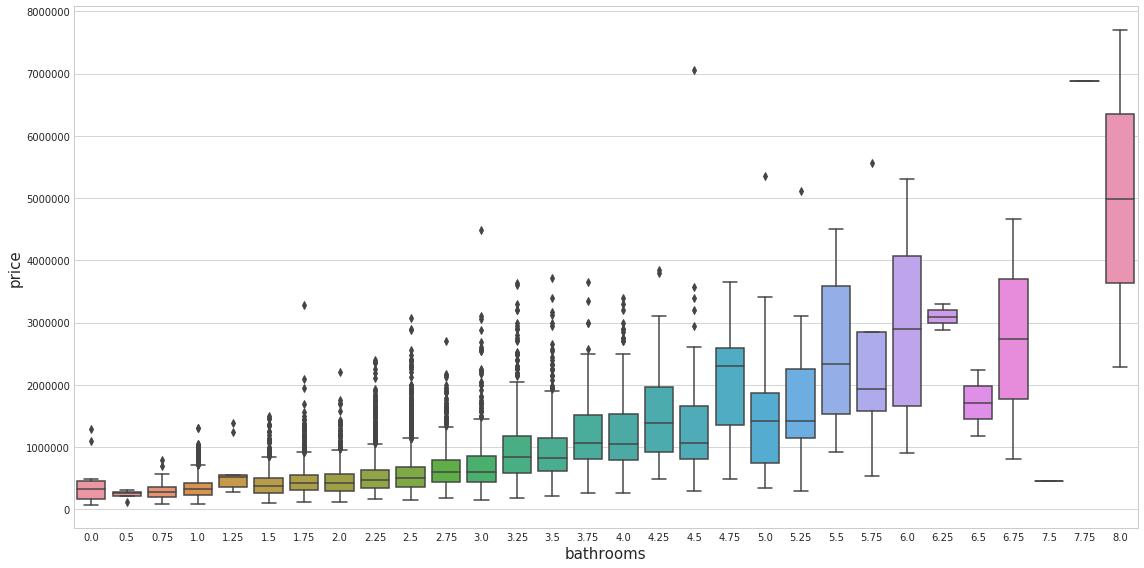

In [5]:
fig, axes = plt.subplots(3,2, figsize=(18,16))
for xcol, ax in zip(['floors', 'waterfront', 'view', 'condition',
                     'grade', 'bedrooms'], axes.flatten()):
    sns.boxplot(xcol, 'price', data=df, ax=ax)
    

fig = plt.figure(figsize=(16, 8))
sns.boxplot('bathrooms', 'price', data=df)

plt.tight_layout()

We can see that some of the features have a linear relation to the target (*price*), but some of them have a non-linear relation, such as the *grade*, which looks more like an exponential relation to price. This seems a bit problematic, considering we are going to use a *linear* regression model. We will learn how to deal with this problem later in this kernel.

Let's have a look at the continuous variables and their relation to the target.

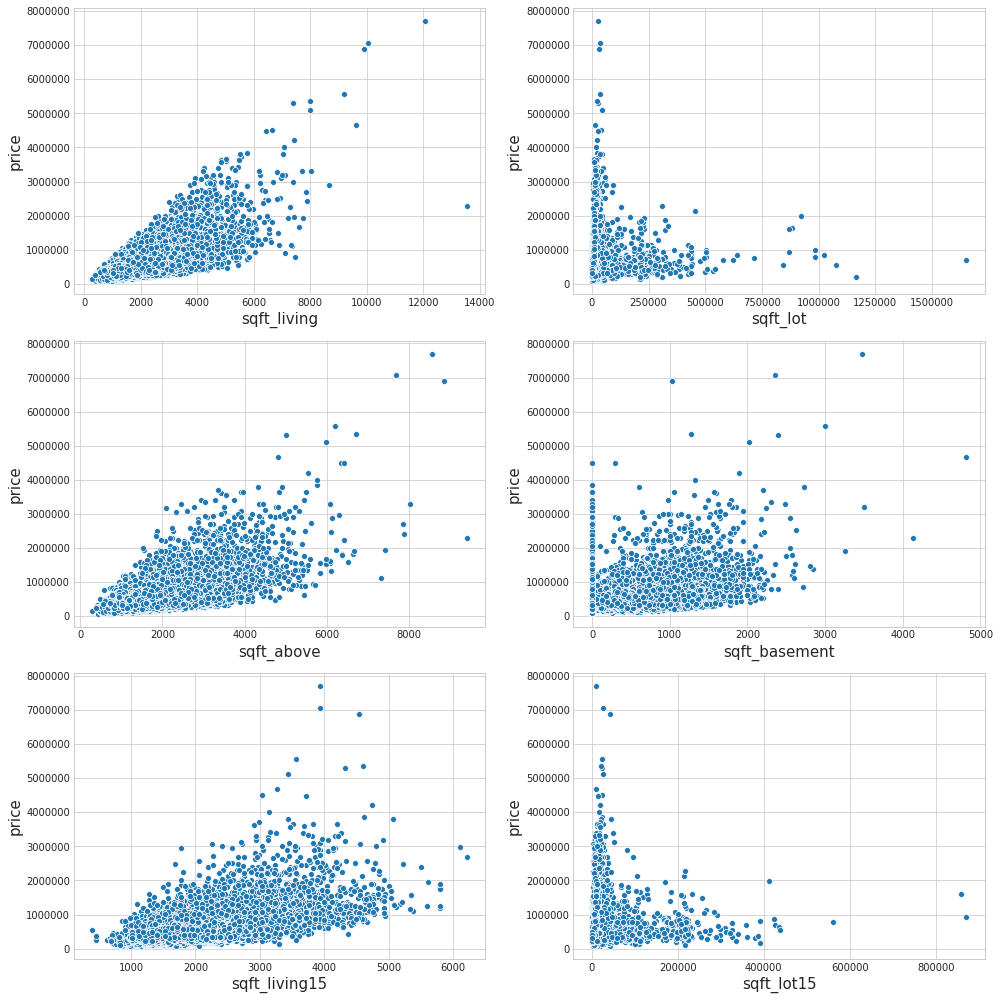

In [6]:
features_cont = ['sqft_living', 'sqft_lot', 'sqft_above','sqft_basement', 
                'sqft_living15', 'sqft_lot15']

fig, axes = plt.subplots(3,2, figsize=(14,14))

for xcol, ax in zip(features_cont, axes.flatten()):
    sns.scatterplot(xcol, 'price', data=df, ax=ax)

plt.tight_layout()

Once again, we can see some features with a more linear relation to *price*, but some of the features reveal more complex relationships, like polynomial, exponential or even a square-root relation. We can see the complex relations clearly with the features such as *sqft_lot* and *sqft_lot15*.

Let's have a look at the price of houses according to their location in Seattle.

In [7]:
def lgn2x(a):
    return a * (np.pi/180) * 6378137

def lat2y(a):
    return np.log(np.tan(a * (np.pi/180)/2 + np.pi/4)) * 6378137


# project coordinates
df['x_coor'] = df['long'].apply(lambda row: lgn2x(row))
df['y_coor'] = df['lat'].apply(lambda row: lat2y(row))

# creating the map
output_file("tile.html")
xmin, xmax =  df['x_coor'].min(), df['x_coor'].max() 
ymin, ymax =  df['y_coor'].min(), df['y_coor'].max() 

# range bounds supplied in web mercator coordinates
map_kc = figure(x_range=(xmin, xmax), y_range=(ymin, ymax),
           x_axis_type="mercator", y_axis_type="mercator", title="House Price on King County, USA",
           plot_width=700, plot_height=500,)

map_kc.title.text_font_size = '16pt'
map_kc.add_tile(CARTODBPOSITRON)

source = ColumnDataSource({'x':df['x_coor'], 'y':df['y_coor'], 'z':df['price']})
colormapper = log_cmap('z', palette=bp.Inferno256, low=df['price'].min(), high=df['price'].max())

map_kc.circle(x ='x', y='y', source=source, color=colormapper)

color_bar = ColorBar(color_mapper=colormapper['transform'], width=18, location=(0,0), 
                     ticker=LogTicker(), label_standoff=12)

color_bar.formatter = NumeralTickFormatter(format='0,0')
# color_bar.formatter = BasicTickFormatter(precision=3)

map_kc.add_layout(color_bar, 'right')

show(map_kc)

We can make two observations from this plot:
1. The northern part of King County region has a higher house prices.
2. The closer the house is to downtown Seattle, the price of the houses increases.

As for the first observation, we can assume that the *lat* feature is important in our model. We can check our assumption by using feature engineering methods, but since we don't have many features compared to the number of data points, we see better results using the entire data set, which negates the need for feature engineering. 

As for the second observation, we can create a new feature that measures the *distance* from each house to downtown Seattle. This feature is a *nonlinear combination* of the *lat* and *long* features, so it doesn't increase the multicollinearity* (see next session).

Let's add the *distance* feature (in km) and have a look at the head of the table.

In [8]:
location = tuple(map(tuple, df[['lat', 'long']].values))
# the distance of every house from downtowm seattle
seattle_dt = (47.6050, -122.3344)

df['distance'] = [distance.distance(seattle_dt, loc).km for loc in location]

# df.drop(['lat', 'long', 'x_coor', 'y_coor'], axis=1, inplace=True)
df.drop(['x_coor', 'y_coor'], axis=1, inplace=True)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,distance
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,11.945427
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,12.949082
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,16.623098
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,10.348172
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,21.797975


# Multicollinearity and Data Manipulation

Collinearity between variables can produce misleading results. While the \\(R^2\\) might not be affected by collinearity, the interpretation of the results are highly affected by it. The presence of collinearity can pose problems in
the regression context, since it can be difficult to separate out the individual effects of collinear variables on the response. In other words, since two correlated variables tend to increase or decrease together, it can be difficult to determine how each one separately is associated with the response (in our case, the price of the house). This phenomena can completely change the coefficient values (and therefore the interpretation of their importance), and in some cases it can even change the sign of the coefficient value. 

Unfortunately, it is not enough to check the correlation matrix, as multicollinearity can occur between three or more variables, even when there is no indication of collinearity between two variables. A better way to assess multicollinearity is by computing the *[Variance Inflation Factor](http://www.statisticshowto.datasciencecentral.com/variance-inflation-factor/)* (\\(VIF\\)). As a rule of thumb, we would like to keep the \\(VIF\\) under 5, as  \\(VIF > 5\\) suggests medium multicollinearity, while \\(VIF > 10\\) suggests high multicollinearity.

Let's have a look at the \\(VIF\\) value of our variables.

In [9]:
def get_vif(data):
    
    X = data.iloc[:,1:]
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    return vif.round(1)

get_vif(df)

/opt/conda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,23.3,bedrooms
1,28.7,bathrooms
2,inf,sqft_living
3,2.4,sqft_lot
4,17.7,floors
5,1.2,waterfront
6,1.6,view
7,35.0,condition
8,150.8,grade
9,inf,sqft_above


You'll see that most of the variables suggest strong multicollinearity; some of the values even go to infinity. To solve this problem, we can create another variable, which will be a linear combination of two highly correlated variables. 

Computing a correlation heatmap will help us choose the features we would like to combine together. 

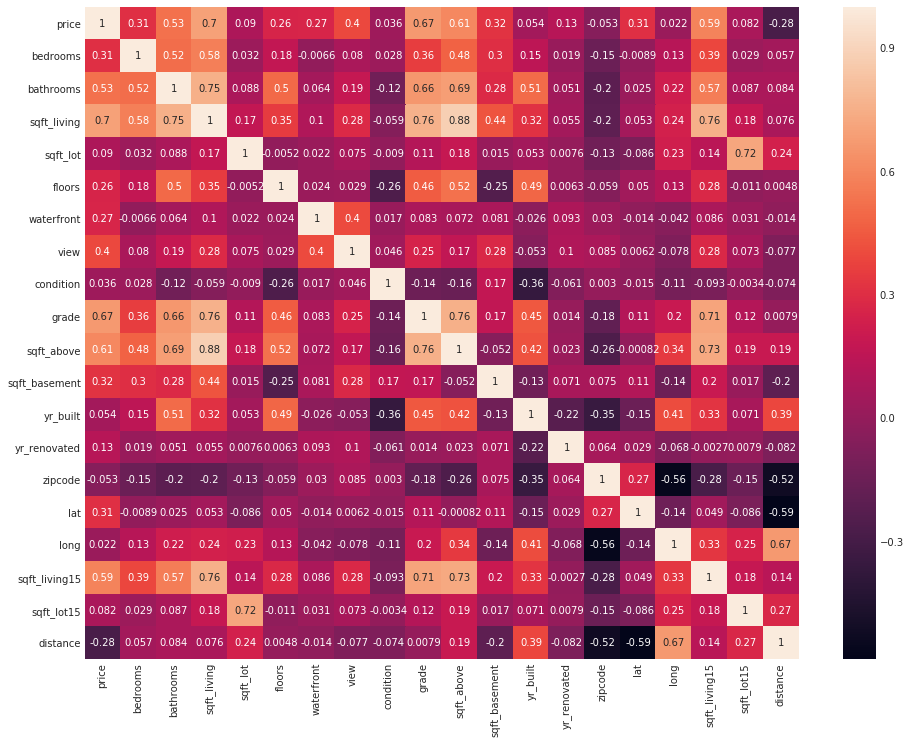

In [10]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True)

As we can see above, we have high correlation between *sqft_living* and *sqft_above*. We can also see high correlation between *sqft_living15* and both *sqft_living* and *sqft_above*. 

Let's create a new variable called *sqft* that will be a linear combination of the three predictors, and will replace these predictors. We can do the same with *sqft_lot* and *sqft_lot15*, creating a new variable called *sqft_lot_comb*. 

Let's have a look at the new table's head.

In [11]:
df['sqft'] = df['sqft_living'] + df['sqft_above'] + df['sqft_living15']
df.drop(['sqft_living', 'sqft_above', 'sqft_living15'], axis=1, inplace=True)

df['sqft_lot_comb'] = df['sqft_lot'] + df['sqft_lot15']
df.drop(['sqft_lot', 'sqft_lot15'], axis=1, inplace=True)

df.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,distance,sqft,sqft_lot_comb
0,221900.0,3,1.00,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,11.945427,3700,11300
1,538000.0,3,2.25,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,12.949082,6430,14881
2,180000.0,2,1.00,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,16.623098,4260,18062
3,604000.0,4,3.00,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,10.348172,4370,10000
4,510000.0,3,2.00,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,21.797975,5160,15583


Let's see the affect on the \\(VIF\\) table.

In [12]:
get_vif(df)

,VIF Factor,features
0,22.9,bedrooms
1,28.0,bathrooms
2,17.2,floors
3,1.2,waterfront
4,1.5,view
5,35.0,condition
6,150.4,grade
7,2.4,sqft_basement
8,11198.9,yr_built
9,1.2,yr_renovated


We can see a big improvement: we no longer have infinite \\(VIF\\) values!  However, we still have some more data manipulation to do for better results. For example, *lat, long, zipcode* and *yr_built* have high \\(VIF\\) values. 

Let's have a look at the data distribution and deal with the polynomial relationships we obsereved earlier between the variables and the target.

# Data Distributuion and Polynomial Relationships

In the plot below, you can see the data distribution of the target. Notice that the target has a right-skewed distribution, meaning, it has a "tail" on the right side. Skewing the data by log-transformation will transform the right-skewed distribution to a normal distribution.

To be clear, there is no need for the target to be normally distributed in order to fit a linear regression model. The normallity assumption in linear regression refers to the error terms between the target and the predicted values (\\(\epsilon\\)), and not the distribution of the target itself. 

However, a log transformation can sometimes solve multiple problems simultaneously: it will linearize some of the polynomial relationships, and help us create a more flexible model that allows [non-linear relashionship with the target](http://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution) (see Bill's answer, poin 2). It will also [reduce outlier influences](https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07). 

Plus, we get normally distributed data, which is always nice to have, and it's important for some statistical hypothesis tests. 

We will use the normality assumption in the next section, when we will carry on with the high multicollinearity issue.

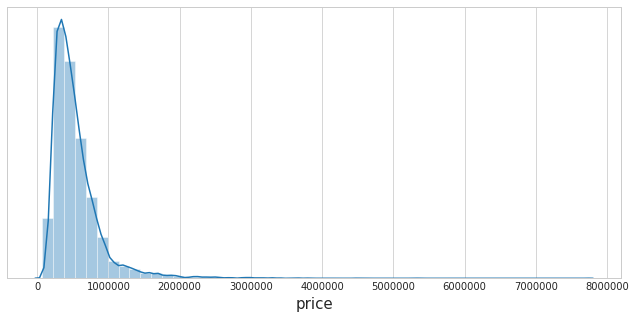

In [13]:
fig = plt.figure(figsize=(11,5))
fig = sns.distplot(df['price'])
fig.set(yticks=[]);

Now, let's look at the skewness factor of the target and the features. 

In order to be normally distributed, the skewness should be zero. A positive skewness is a right-skewed data. 

In [14]:
# computing skewness factor
skewness = df.apply(lambda x: skew(x))
skewness

price             4.023790
bedrooms          1.974163
bathrooms         0.511072
floors            0.616134
waterfront       11.384318
view              3.395514
condition         1.032733
grade             0.771050
sqft_basement     1.577856
yr_built         -0.469773
yr_renovated      4.549178
zipcode           0.405633
lat              -0.485237
long              0.884992
distance          0.767885
sqft              1.314881
sqft_lot_comb     9.944320
dtype: float64

Let's do a log transformation on the data where *skewness*  \\(> 0.75\\), and have a look on the affect on the *price* distribution.

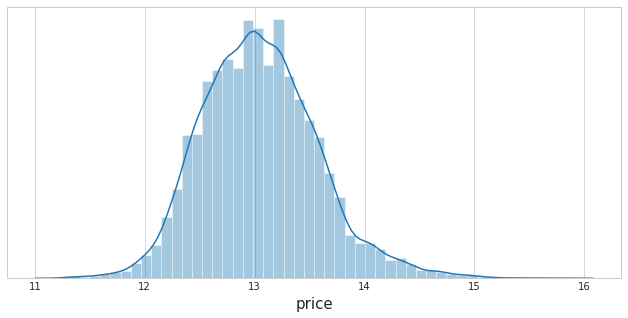

In [15]:
# converting longtitude to positive values to enable us using the log function on all data
# this operation doesn't affect results, as all the whole 'long' column is negative
df['long'] = abs(df['long'])

skewed = skewness[skewness > 0.75].index

df[skewed] = np.log1p(df[skewed])

# plot the new target ditribution
fig = plt.figure(figsize=(11,5))
fig = sns.distplot(df['price'])
fig.set(yticks=[]);

We can see that the *price* is now normally distributed.

Let's have a look at some of the predictors and their relation to the target.

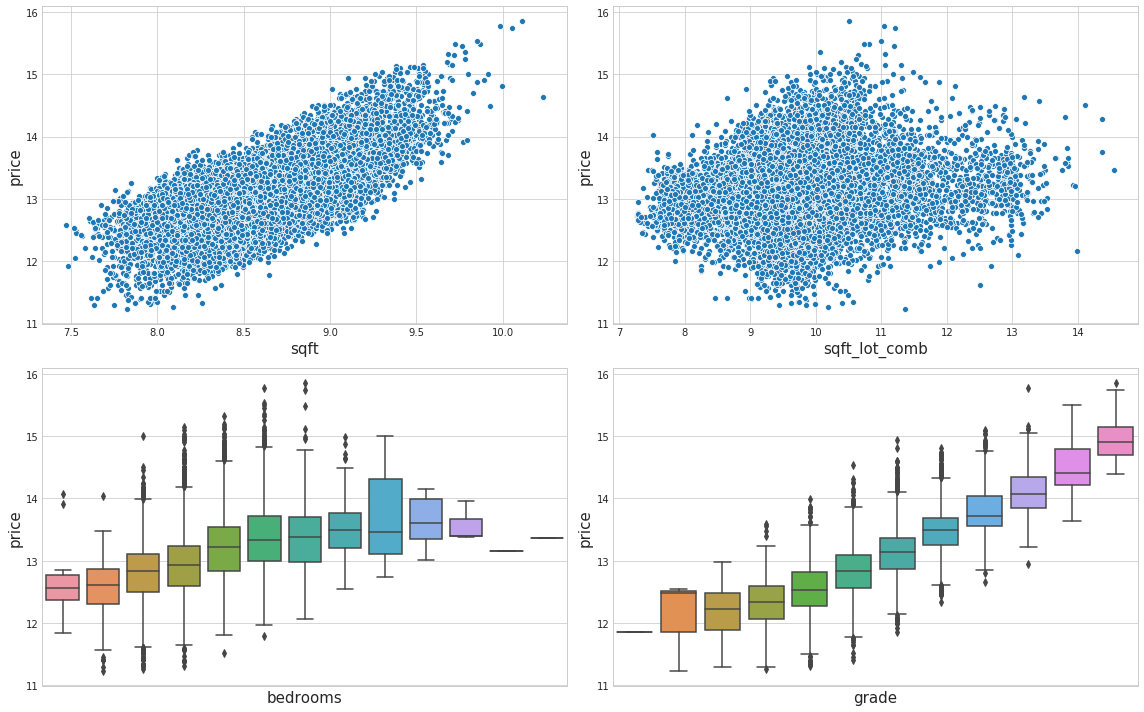

In [16]:
fig, axes = plt.subplots(2,2, figsize=(16,10))

sns.scatterplot('sqft', 'price', data=df, ax=axes[0,0])
sns.scatterplot('sqft_lot_comb', 'price', data=df, ax=axes[0,1])
sns.boxplot('bedrooms', 'price', data=df, ax=axes[1,0])
sns.boxplot('grade', 'price', data=df, ax=axes[1,1])
axes[1,0].set_xticks([])
axes[1,1].set_xticks([])

plt.tight_layout()

Above we can see the change in the relationship between some of the features and the target. We also see that what once was a nonlinear relation between the feature to the *price* now have a more linear relationship to it. Moreover, we've reduced the outliers' affect. 

This dramatically increases the accuracy of our model. 

Notice that it has no affect on the multicollinearity.

In [17]:
get_vif(df)

,VIF Factor,features
0,81.8,bedrooms
1,27.7,bathrooms
2,19.9,floors
3,1.2,waterfront
4,1.5,view
5,136.7,condition
6,847.8,grade
7,2.5,sqft_basement
8,12407.8,yr_built
9,1.2,yr_renovated


# Data Standardization 

Going back dealing with the high  \\(VIF\\), we can use [data standardization to reduce multicollinearity](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/). In fact, only by centering the data, we will lower the \\(VIF\\) values (the scaling part is a matter of preference). 

Under the assumption that the data has a symetric distribution (like normal distribution), the correlation created by interaction terms will be zero. For the full mathematical explanation, see [this link](https://psychometroscar.com/why-does-centering-in-linear-regression-reduces-multicollinearity/).

Let's see the affect of standardizing the data on the \\(VIF\\).

In [18]:
# Standardizing the data
df = (df - df.mean()) / df.std()

get_vif(df)

,VIF Factor,features
0,1.7,bedrooms
1,3.2,bathrooms
2,2.3,floors
3,1.2,waterfront
4,1.3,view
5,1.2,condition
6,3.2,grade
7,1.5,sqft_basement
8,2.8,yr_built
9,1.1,yr_renovated


As you can see, standardizing the data has a huge affect on the \\(VIF\\) values. 

Now we are ready to fit the model and get predictions!

# House Price Prediction

Now, we will predict house prices using a simple linear regression and a k-fold cross-validation. The fitted model will be tested with the R-squared adjusted test, so it will not be affected by the number of features I chose to use in the model (like in the R-squared test).

In [19]:
def split_kfold(folds, i):    
    train = folds.copy() 
    test = folds[i]
    del train[i]
    train = np.concatenate(train, axis=0)
    d = train.shape[1]-1
    x_train, y_train = train[:, :d], train[:, d]
    x_test, y_test = test[:, :d], test[:, d]
    
    return x_train, x_test, y_train, y_test


def get_error(Y, Yhat):
    N = len(Y)   
    d1 = Y - Yhat
    d2 = Y - Y.mean()
    r2 = 1 - (d1.dot(d1) / d2.dot(d2))
    r2_adj = 1 - (1 - r2)*((N - 1) / (N - D - 1))
    mse = d1.dot(d1) / N
    return r2_adj, mse


def fit_kfold(X, Y, X_test, Y_test):
    w = np.linalg.solve(X.T.dot(X), X.T.dot(Y))
    Yhat = X.dot(w)
    Yhat_test =  X_test.dot(w)
    r2_test, mse_test = get_error(Y_test, Yhat_test)
    
    return r2_test, w


In [20]:
# df_array = df[features].values
X = df.iloc[:,1:]
Y = df.iloc[:,0]

df_array = np.c_[X.values, Y.values]
k = 7
D = X.shape[1]
folds = np.array_split(df_array, k)

r2_test = []
coef = []

for i in range(k):
    x_train, x_test, y_train, y_test = split_kfold(folds, i)
    # prepare the array
    x_train = np.c_[np.ones(x_train.shape[0]), x_train]
    x_test = np.c_[np.ones(x_test.shape[0]), x_test]
    
    r2_test_temp, w = fit_kfold(x_train, y_train, x_test, y_test)
    r2_test.append(r2_test_temp)
    coef.append(w)
    
r2_test_kfold = sum(r2_test) / len(r2_test)
coef = np.sum(coef, axis=0) / len(coef)

indx = list(df.columns)
indx[0] = 'bias'
coef = pd.DataFrame(coef, index=indx, columns=['coef'])

print('Using  k-fold cross-validation where k = ', k,':')
print('R2_adjusted of the test data, using a simple linear regression, is: ', r2_test_kfold)

Using  k-fold cross-validation where k =  7 :
R2_adjusted of the test data, using a simple linear regression, is:  0.8219293314997594


Notice that the \\(R^2\\) is higher than the everage \\(R^2\\) from other notebooks that used a linear regression model. 

Let's have a look at the coefficients.

In [21]:
coef.reindex(coef['coef'].abs().sort_values(ascending=False).index)

,coef
sqft,0.434615
distance,-0.415658
grade,0.269826
lat,0.242776
long,-0.113583
zipcode,-0.103421
view,0.089742
waterfront,0.082675
condition,0.080104
yr_built,-0.072453


Above you can see the coefficients sorted by their importance. We can see that the features *sqft, distance, grade* and *lat* have the greatest affect on the *price*. The negative coefficients imply that the increase of these features lowers the price of the house. For example, as the houses' distance from downtwon Seattle increases, the price of the house decreases.

Because we used log-transformation on the data and standardized it, it cannot be interpreted using traditional or straightforward methods. More information on how to interpret the coefficients will be added soon.

# Summary

### We fit a simple linear model and got a great \\(R^2\\) result! 
**How did we do it?**
1. Data manipulation: we created the *distance* feature.
2. Log-transformation of the data: created a more flexible model that allows non-linear relationships with the target.

### Lowered multicollinearity and got statistically significant results! 
**How did we do it?**
1. Created new features to replace highly correlated ones with their linear combination. 
2. Standardizing the data to reduce correlations caused by interaction terms.

**I hope you enjoy my notebook! If you did, please UPVOTE!**

If you have a comment or ideas for improvement, please leave a comment below.

See you on my next kernel :)